In [21]:
from matplotlib import pyplot as plt

from confutils import get_initial_structure, get_dihedral_info, set_dihedrals_and_relax, relax_structure
from tqdm import tqdm
import pickle as pkl
import pandas as pd
import numpy as np
import time
import tensorflow as tf
import random
from graphviz import Digraph
import pydot_ng as pydot
from keras_visualizer import visualizer

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from collections import deque

This is my first go at the group project. It currently can one 1 round and actually does minimize energy. That's progress. I'm getting an error with the modified tensor board which I didnt make and I don't know what to do with it. That's my next prject. If you want to have a go at fixing it, be my guest.

# Things you can do:
    
   1) The convergence criterion doesn't work because it osicillates around a plateau and doesnt ever get to a point where it continually gets worse at the end. Please implement a new finishing criterion that takes the average over the last 100 steps. If the average over 100 steps stops changing significantly, we will define that plateau.
   -This requires that you look at the percentage that it changes by at each step and select a percentage that defines a plateau.
   
   
   2) You can pull your own version of this and try to define the intial functions and classes in .py files that can be imported. This got messy with the dependencies so I just shoved them all in here.
   3) Find a way to evaluate the accuracy of the fit and prediction of the q values. Add this to the DQNagent. Ask it to plot error as it goes so we can see how it's performing. 
   
   
   4) plot all energy values as each game progresses. Do you see any local minima
   
   
   5) the MAIN thing we need is to get it to run for multiple rounds.

In [2]:
def evaluate_energy(angles):
    """Compute the energy of a cysteine molecule given dihedral angles
    
    Args:
        angles: List of dihedral angles
    Returns:
        energy of the structure
    """
    return set_dihedrals_and_relax(
        cysteine,
        zip(angles, dihedrals)
    )

In [3]:
WIN_REWARD=100
MOVE_REWARD=1
epsilon=.9
eps_decay=.9998
start_q_table= None
learning=.1
discount=.95
def get_all(smiles,backbone_atoms,backbone_bonds):
    atoms, bonds = get_initial_structure(smiles)
   
    start_energy = relax_structure(atoms)
    diheds=[]
    for i in backbone_bonds:
        di=get_dihedral_info(bonds,i, backbone_atoms=backbone_atoms)
        diheds.append(di)
        
    init_state=np.random.uniform(-180,180,len(diheds))
    
    energy=set_dihedrals_and_relax(
        atoms,
        zip(init_state, diheds)
    )
    
    return atoms, diheds,energy,init_state

      
    
get_all('C([C@@H](C(=O)O)N)S',[0, 1, 3, 5, 6, 7],[[1,3],[1, 0],[1, 6],[3, 5],[0, 7]])  

(Atoms(symbols='C2HCO2NSH6', pbc=False, constraint=FixInternals(_copy_init=[FixDihedral(138.62071182734076, [0, 1, 3, 5]), FixDihedral(3.50578760960272, [3, 1, 0, 7]), FixDihedral(153.17358396358458, [0, 1, 6, 11]), FixDihedral(44.33541664286625, [1, 3, 5, 10]), FixDihedral(155.21928711328815, [1, 0, 7, 13])], epsilon=1e-07), calculator=Calculator(...)),
 [DihedralInfo(chain=[0, 1, 3, 5], group={10, 3, 4, 5}),
  DihedralInfo(chain=[3, 1, 0, 7], group={0, 7, 8, 9, 13}),
  DihedralInfo(chain=[0, 1, 6, 11], group={11, 12, 6}),
  DihedralInfo(chain=[1, 3, 5, 10], group={10, 5}),
  DihedralInfo(chain=[1, 0, 7, 13], group={13, 7})],
 -19640.86836712484,
 array([138.62071183,   3.50578761, 153.17358396,  44.33541664,
        155.21928711]))

In [5]:
class ModifiedTensorBoard(TensorBoard):

    # Overriding init to set initial step and writer (we want one log file for all .fit() calls)
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.step = 1
        #self.writer = tf.summary.FileWriter(self.log_dir)

    # Overriding this method to stop creating default log writer
    def set_model(self, model):
        pass
    
    def _write_logs(self, logs, index):
        with self.writer.as_default():
            for name, value in logs.items():
                tf.summary.scalar(name, value, step=index)
                self.step += 1
                self.writer.flush()
            
            
    def update_stats(self, **stats):
        self._write_logs(stats, self.step)


    
    
    
    
    
    # Overrided, saves logs with our step number
    # (otherwise every .fit() will start writing from 0th step)
    def on_epoch_end(self, epoch, logs=None):
        self.update_stats(**logs)

    # Overrided
    # We train for one batch only, no need to save anything at epoch end
    def on_batch_end(self, batch, logs=None):
        pass

    # Overrided, so won't close writer
    def on_train_end(self, _):
        pass

    # Custom method for saving own metrics
    # Creates writer, writes custom metrics and closes writer
    #def update_stats(self, **stats):
        #with open("stats.txt",'a') as data:
            #data.write("{} {} {} {}".format(reward_avg, reward_min, reward_max, epsilon))
            
        #self._write_logs(stats, self.step)

In [4]:
class Molecule:
    def __init__(self,smiles,backbone_atoms,backbone_bonds):
        self.bbonds=backbone_bonds
        self.n_choices=len(self.bbonds)
        self.atoms, self.dihedrals, self.energy, self.angles=get_all(smiles,backbone_atoms,backbone_bonds)
    def get_energy(self):
        self.energy=set_dihedrals_and_relax(self.atoms,zip(self.angles, self.dihedrals))
        return self.energy
    choices=[]
    def action(self,choice):
        if choice==0:
            self.angles[0]+=1.0
            if abs(self.angles[0])>180:
                self.angles[0]=self.angles[0]%180
        if choice==1:
            self.angles[0]-=1.0
            if abs(self.angles[0])>180:
                self.angles[0]=self.angles[0]%180
        if choice==2:
            self.angles[1]+=1.0
            if abs(self.angles[1])>180:
                self.angles[1]=self.angles[1]%180
        if choice==3:
            self.angles[1]-=1.0
            if abs(self.angles[1])>180:
                self.angles[1]=self.angles[1]%180
            
       

            
class MolEnv:
    mol = Molecule('OCC',[0, 1, 2],[[0,1],[1,2]])
    SIZE = 360 #We dont have a finite size in this way
    RETURN_IMAGES = False
    ENERGY_REWARD=1
    MIN_REWARD = 25
    OBSERVATION_SPACE_VALUES = [360 for i in range(mol.n_choices)]
    OBSERVATION_SPACE_VALUES.append(mol.n_choices)# 4 #WHAT IS GOING ON HERE
    ACTION_SPACE_SIZE = mol.n_choices*2
    print(mol.n_choices,"N_CHOICES")
    OBSERVATION_SPACE_VALUES=tuple(OBSERVATION_SPACE_VALUES)
    reward=0
    MAX_STEPS=200000
    EXIT=False
    min_energy=mol.get_energy()+.05
    def __init__(self):
        self.energy_list=[]
        self.mol = Molecule('OCC',[0, 1, 2],[[0,1],[1,2]])
        self.ener=self.mol.get_energy()
        self.min_energy=self.ener+.05
        self.reward=0
        self.EXIT==False
    def reset(self):
        self.mol = Molecule('OCC',[0, 1, 2],[[0,1],[1,2]])
        self.ener=self.mol.get_energy()
        
        self.strikes=0
        self.energy_list=[]
        self.energy_list.append(self.ener)
        OBSERVATION_SPACE_VALUES = [360 for i in range(self.mol.n_choices)]
        OBSERVATION_SPACE_VALUES.append(self.mol.n_choices)# 4 #WHAT IS GOING ON HERE
        
        OBSERVATION_SPACE_VALUES=tuple(OBSERVATION_SPACE_VALUES)
        self.episode_step = 0

        if self.RETURN_IMAGES:
            observation = np.array(self.get_image())
        else:
            observation = self.mol.angles
        return observation

    def step(self, action):
        self.reward=0
        self.episode_step += 1
        
        self.mol.action(action)
        new_ener=self.mol.get_energy()
        print(new_ener,"NEW EN")
        self.energy_list.append(new_ener)
    
        
        
        new_observation = self.mol.angles
        
        done = False
        
        if abs(new_ener)<=abs(self.min_energy):
            self.min_energy=new_ener
            self.reward=10000
            plt.plot(np.arange(0,len(self.energy_list)),self.energy_list)
            #plt.plot(np.arange(0,len(energy_list)),energy_list)
            done = True
        #if abs(self.energy_list[self.episode_step])>abs(self.energy_list[self.episode_step-1]):
            #self.strike+=1
        #else:
            #self.strike=0
            
        #if abs(self.energy_list[self.episode_step])<abs(self.energy_list[self.episode_step-1]) and self.episode_step<20:
            #self.reward=self.ENERGY_REWARD
        #else:
            #self.reward=-self.ENERGY_REWARD
            
        if self.episode_step>MAX_STEPS and new_ener==self.min_energy:
            done=True
        

        
        

        return new_observation, self.reward, done, self.mol.angles

    def render(self):
        img = self.get_image()
        img = img.resize((300, 300))  # resizing so we can see our agent in all its glory.
        cv2.imshow("image", np.array(img))  # show it!
        cv2.waitKey(1)

    # FOR CNN #
    def get_image(self):
        env = np.zeros((self.SIZE, self.SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
        env[self.food.x][self.food.y] = self.d[self.FOOD_N]  # sets the food location tile to green color
        env[self.enemy.x][self.enemy.y] = self.d[self.ENEMY_N]  # sets the enemy location to red
        env[self.player.x][self.player.y] = self.d[self.PLAYER_N]  # sets the player tile to blue
        img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
        return img



2 N_CHOICES


In [5]:
REPLAY_MEMORY_SIZE = 4000
MIN_REPLAY_MEMORY_SIZE = 1000
MODEL_NAME = "256x2"
DISCOUNT=0.99
MINIBATCH_SIZE = 64  # How many steps (samples) to use for training
UPDATE_TARGET_EVERY = 5  # Terminal states (end of episodes)
MIN_EPSILON=.5
class DQNAgent:
    
    def __init__(self,env):

        # main model  # gets trained every step
        self.model = self.create_model()

        # Target model this is what we .predict against every step
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
        #self.tensorboard = ModifiedTensorBoard(log_dir=f"logs/{MODEL_NAME}-{int(time.time())}")
        self.target_update_counter = 0

    def create_model(self):
        
        model = Sequential()
        #model.add(Conv2D(256, (3, 3), input_shape=env.OBSERVATION_SPACE_VALUES))
        #model.add(keras.Input(shape=(REPLAY_MEMORY_SIZE,a1.n_choices)))
        model.add(keras.Input(shape=(a1.n_choices)))
        model.add(Dense(a1.n_choices))

        #model.add(Flatten())
        
        model.add(Dense(a1.n_choices,activation='linear'))

        model.add(Dense(env.ACTION_SPACE_SIZE, activation='linear'))
        model.compile(loss="mse", optimizer=Adam(lr=0.001), metrics=['accuracy'])
        return model

    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    def get_qs(self, state, step):
        #print(*state.shape)
        return self.model.predict(np.array(state).reshape(-1, *state.shape)/180)[0]
    def train(self, terminal_state,step):
        if len(self.replay_memory)<MIN_REPLAY_MEMORY_SIZE:
            return
    # Get a minibatch of random samples from memory replay table
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])/180
        current_qs_list = self.model.predict(current_states)

        # Get future states from minibatch, then query NN model for Q values
        # When using target network, query it, otherwise main network should be queried
        new_current_states = np.array([transition[3] for transition in minibatch])/180
        future_qs_list = self.target_model.predict(new_current_states)
        
        X = []
        y = []

        # Now we need to enumerate our batches
        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):

            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            y.append(current_qs)

        # Fit on all samples as one batch, log only on terminal state
        self.model.fit(np.array(X)/180, np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False)

        # Update target network counter every episode
                # Update target network counter every episode
        if terminal_state:
            self.target_update_counter += 1

        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

In [7]:

a1=Molecule('OCC',[0, 1, 2],[[0,1],[1,2]])
print(a1.angles)
a1.action(2)
print(a1.angles)

[ 173.36344704 -147.25760932]
[ 173.36344704 -146.25760932]


# This is the part that actually runs the code

In [8]:
env=MolEnv()
EPISODES = 15
agent = DQNAgent(env)
epsilon=.9
EPSILON_DECAY=.98
AGGREGATE_STATS_EVERY=10
MAX_STEPS=200000

  7%|6         | 1/15 [00:01<00:26,  1.91s/episodes]

-4217.392931066949 NEW EN
-4217.433923396603 NEW EN
-4217.432410698117 NEW EN
-4217.431007023401 NEW EN
-4217.432411002228 NEW EN
-4217.431007226142 NEW EN
-4217.432541668561 NEW EN
-4217.430969364331 NEW EN
-4217.429209879819 NEW EN
-4217.430861658374 NEW EN
-4217.432581507093 NEW EN
-4217.434297706482 NEW EN
-4217.432599348268 NEW EN
-4217.434297959908 NEW EN
-4217.432581405723 NEW EN
-4217.434366283498 NEW EN
-4217.4325817605195 NEW EN
-4217.434366131442 NEW EN
-4217.436209702629 NEW EN
-4217.434351939599 NEW EN
-4217.436209702629 NEW EN
-4217.434366232813 NEW EN
-4217.432487384758 NEW EN
-4217.434366536924 NEW EN
-4217.432581709834 NEW EN
-4217.434298517444 NEW EN
-4217.432599652379 NEW EN
-4217.430968958849 NEW EN
-4217.42941307661 NEW EN
-4217.427933678271 NEW EN
-4217.429551244346 NEW EN
-4217.4310076823085 NEW EN
-4217.429411961537 NEW EN
-4217.43096926296 NEW EN
-4217.432541313765 NEW EN
-4217.431008037105 NEW EN
-4217.429551396402 NEW EN
-4217.428177473873 NEW EN
-4217.426535

 13%|#3        | 2/15 [04:27<34:01, 157.02s/episodes]

-4217.392173070438 NEW EN


 20%|##        | 3/15 [04:29<17:16, 86.36s/episodes] 

-4217.378685192842 NEW EN


 27%|##6       | 4/15 [04:31<09:42, 52.92s/episodes]

-4217.35603632806 NEW EN
-4217.494738944267 NEW EN
-4217.495975662077 NEW EN
-4217.4955931918885 NEW EN
-4217.494344816492 NEW EN
-4217.493767309822 NEW EN
-4217.492456693054 NEW EN
-4217.491096607573 NEW EN
-4217.489688675304 NEW EN
-4217.48823664695 NEW EN
-4217.488870211402 NEW EN
-4217.487394867876 NEW EN
-4217.488871022365 NEW EN
-4217.488236241469 NEW EN
-4217.489689283526 NEW EN
-4217.4882369510615 NEW EN
-4217.488871225106 NEW EN
-4217.490306425988 NEW EN
-4217.488870211402 NEW EN
-4217.488236748321 NEW EN
-4217.48674386773 NEW EN
-4217.488236849691 NEW EN
-4217.486744678693 NEW EN
-4217.487394462395 NEW EN
-4217.488871225106 NEW EN
-4217.489325161364 NEW EN
-4217.489598252986 NEW EN
-4217.491001522219 NEW EN
-4217.490743636145 NEW EN
-4217.489324958624 NEW EN
-4217.490744751219 NEW EN
-4217.491000407146 NEW EN
-4217.489598658467 NEW EN
-4217.489324553142 NEW EN
-4217.487865834348 NEW EN
-4217.486371635943 NEW EN
-4217.485882828297 NEW EN
-4217.485214595198 NEW EN
-4217.4836533

 33%|###3      | 5/15 [06:46<13:44, 82.43s/episodes]

-4217.355542908065 NEW EN
-4217.423752456997 NEW EN
-4217.425417160267 NEW EN
-4217.422130329259 NEW EN
-4217.418750947156 NEW EN
-4217.420500142581 NEW EN
-4217.423862899953 NEW EN
-4217.427130318546 NEW EN
-4217.430296670937 NEW EN
-4217.428602418222 NEW EN
-4217.425417464378 NEW EN
-4217.428602975759 NEW EN
-4217.426957076682 NEW EN
-4217.423752203572 NEW EN
-4217.4221456361765 NEW EN
-4217.425369110739 NEW EN
-4217.426958445181 NEW EN
-4217.430055105484 NEW EN
-4217.433037521443 NEW EN
-4217.435899965639 NEW EN
-4217.433037724184 NEW EN
-4217.435899762898 NEW EN
-4217.437483674029 NEW EN
-4217.440198776475 NEW EN
-4217.442782908478 NEW EN
-4217.444371482643 NEW EN
-4217.446005065227 NEW EN
-4217.444372496347 NEW EN
-4217.446798389292 NEW EN
-4217.445231711114 NEW EN
-4217.447537378868 NEW EN
-4217.449699303521 NEW EN
-4217.448221222996 NEW EN
-4217.446039632504 NEW EN
-4217.448222743551 NEW EN
-4217.449700013112 NEW EN
-4217.451226041795 NEW EN
-4217.452798599451 NEW EN
-4217.45477

 40%|####      | 6/15 [08:12<12:34, 83.81s/episodes]

-4217.33601275163 NEW EN
-4217.489599165318 NEW EN
-4217.4903429193 NEW EN
-4217.488130613603 NEW EN
-4217.485778011394 NEW EN
-4217.488131525936 NEW EN
-4217.485778315505 NEW EN
-4217.485022599826 NEW EN
-4217.48252483533 NEW EN
-4217.479894579835 NEW EN
-4217.47905563913 NEW EN
-4217.479894478464 NEW EN
-4217.4790553350185 NEW EN
-4217.476291574822 NEW EN
-4217.477136597746 NEW EN
-4217.474257072653 NEW EN
-4217.4712598566275 NEW EN
-4217.468154275738 NEW EN
-4217.464943168353 NEW EN
-4217.4640817234385 NEW EN
-4217.460772793703 NEW EN
-4217.457376584128 NEW EN
-4217.453897250896 NEW EN
-4217.450347465297 NEW EN
-4217.449422359827 NEW EN
-4217.452968496094 NEW EN
-4217.453897453636 NEW EN
-4217.45475200537 NEW EN
-4217.451196441663 NEW EN
-4217.447574277662 NEW EN
-4217.443894332583 NEW EN
-4217.447573263959 NEW EN
-4217.446732802699 NEW EN
-4217.447573872181 NEW EN
-4217.448338102966 NEW EN
-4217.447574379033 NEW EN
-4217.446731079404 NEW EN
-4217.4503470598165 NEW EN
-4217.44673229

 47%|####6     | 7/15 [31:17<1:07:52, 509.11s/episodes]

-4217.334504918918 NEW EN
-4217.474531177978 NEW EN
-4217.474747502224 NEW EN
-4217.474530569756 NEW EN
-4217.474748313187 NEW EN
-4217.474764329696 NEW EN
-4217.473397046923 NEW EN
-4217.473376874231 NEW EN
-4217.473397553775 NEW EN
-4217.473218432433 NEW EN
-4217.472840118427 NEW EN
-4217.474201318982 NEW EN
-4217.473621176684 NEW EN
-4217.472262713128 NEW EN
-4217.473620872573 NEW EN
-4217.4722637268305 NEW EN
-4217.471487939831 NEW EN
-4217.4722635240905 NEW EN
-4217.470909013977 NEW EN
-4217.46956342445 NEW EN
-4217.468230202102 NEW EN
-4217.469562410747 NEW EN
-4217.468793212817 NEW EN
-4217.46956342445 NEW EN
-4217.470133125606 NEW EN
-4217.468798078592 NEW EN
-4217.469167370639 NEW EN
-4217.470506776577 NEW EN
-4217.47185763736 NEW EN
-4217.470506066985 NEW EN
-4217.470133429717 NEW EN
-4217.471482871315 NEW EN
-4217.471857333248 NEW EN
-4217.471483378166 NEW EN
-4217.470908811236 NEW EN
-4217.47226342272 NEW EN
-4217.470909216717 NEW EN
-4217.471482263093 NEW EN
-4217.47090881

 53%|#####3    | 8/15 [33:29<45:24, 389.23s/episodes]  

-4217.334036131909 NEW EN
-4217.357149931627 NEW EN
-4217.355849046408 NEW EN
-4217.357150387794 NEW EN
-4217.355850009427 NEW EN
-4217.359112967726 NEW EN
-4217.355850009427 NEW EN
-4217.352720707884 NEW EN
-4217.355849756001 NEW EN
-4217.359114082799 NEW EN
-4217.357801033144 NEW EN
-4217.359113778689 NEW EN
-4217.360411825538 NEW EN
-4217.361692233954 NEW EN
-4217.365077039369 NEW EN
-4217.366334233983 NEW EN
-4217.369831154963 NEW EN
-4217.368574619257 NEW EN
-4217.369830496056 NEW EN
-4217.371061283704 NEW EN
-4217.374659828422 NEW EN
-4217.37106331111 NEW EN
-4217.3698314083895 NEW EN
-4217.373428483238 NEW EN
-4217.369830850852 NEW EN
-4217.36633489289 NEW EN
-4217.362951405289 NEW EN
-4217.366335247686 NEW EN
-4217.369831459075 NEW EN
-4217.37342888872 NEW EN
-4217.369831965926 NEW EN
-4217.368574365831 NEW EN
-4217.372174228363 NEW EN
-4217.3685751767935 NEW EN
-4217.369830293315 NEW EN
-4217.373429243516 NEW EN
-4217.369831205649 NEW EN
-4217.373428990089 NEW EN
-4217.3698302

 60%|######    | 9/15 [37:26<34:09, 341.65s/episodes]

-4217.332721815124 NEW EN
-4217.485244296699 NEW EN
-4217.483461497016 NEW EN
-4217.484840741486 NEW EN
-4217.486619080876 NEW EN
-4217.484840944227 NEW EN
-4217.486619384987 NEW EN
-4217.487934157938 NEW EN
-4217.4895346938 NEW EN
-4217.490955398728 NEW EN
-4217.4921969823135 NEW EN
-4217.490954790506 NEW EN
-4217.492196678203 NEW EN
-4217.493255491116 NEW EN
-4217.494490384261 NEW EN
-4217.495665164811 NEW EN
-4217.494617097151 NEW EN
-4217.493386056078 NEW EN
-4217.494617604002 NEW EN
-4217.495735211696 NEW EN
-4217.49461669167 NEW EN
-4217.49566496207 NEW EN
-4217.496779123173 NEW EN
-4217.497639351644 NEW EN
-4217.4983100176305 NEW EN
-4217.4972034593 NEW EN
-4217.498310423111 NEW EN
-4217.497639351644 NEW EN
-4217.498309510779 NEW EN
-4217.499358794882 NEW EN
-4217.49983837783 NEW EN
-4217.500826028783 NEW EN
-4217.501113920471 NEW EN
-4217.501212452414 NEW EN
-4217.501121725984 NEW EN
-4217.50084457955 NEW EN
-4217.500382432297 NEW EN
-4217.500844782291 NEW EN
-4217.501760865804

 67%|######6   | 10/15 [1:08:10<1:07:05, 805.18s/episodes]

-4217.306488344043 NEW EN
-4217.435205832425 NEW EN
-4217.435218047548 NEW EN
-4217.4352051228325 NEW EN
-4217.437510942643 NEW EN
-4217.439665112466 NEW EN
-4217.441664591192 NEW EN
-4217.441644469185 NEW EN
-4217.443473848527 NEW EN
-4217.443507604841 NEW EN
-4217.4436392848775 NEW EN
-4217.441786032827 NEW EN
-4217.443638980766 NEW EN
-4217.443868990004 NEW EN
-4217.443638778025 NEW EN
-4217.44533095265 NEW EN
-4217.445571504401 NEW EN
-4217.4471127386305 NEW EN
-4217.447455167546 NEW EN
-4217.448843129862 NEW EN
-4217.447454863434 NEW EN
-4217.448842825751 NEW EN
-4217.44848873925 NEW EN
-4217.448842724381 NEW EN
-4217.447454762064 NEW EN
-4217.448842724381 NEW EN
-4217.450064033905 NEW EN
-4217.449700013112 NEW EN
-4217.450741897183 NEW EN
-4217.451615912017 NEW EN
-4217.45200345072 NEW EN
-4217.452722267605 NEW EN
-4217.453206817699 NEW EN
-4217.452723281309 NEW EN
-4217.45320702044 NEW EN
-4217.453772666782 NEW EN
-4217.454415455933 NEW EN
-4217.453772666782 NEW EN
-4217.4532074

 73%|#######3  | 11/15 [1:08:52<38:07, 571.82s/episodes]  

-4217.303301210737 NEW EN
-4217.437940651397 NEW EN
-4217.440250678075 NEW EN
-4217.439615542383 NEW EN
-4217.439051974132 NEW EN
-4217.43856478841 NEW EN
-4217.438154289331 NEW EN
-4217.435834074936 NEW EN
-4217.4381551002925 NEW EN
-4217.437823619372 NEW EN
-4217.435501326886 NEW EN
-4217.433031287169 NEW EN
-4217.43042044409 NEW EN
-4217.430164990902 NEW EN
-4217.427416841734 NEW EN
-4217.424541016658 NEW EN
-4217.4215427869285 NEW EN
-4217.418427575859 NEW EN
-4217.415205013629 NEW EN
-4217.41188052355 NEW EN
-4217.408461150859 NEW EN
-4217.408707227291 NEW EN
-4217.4084615056545 NEW EN
-4217.408300630969 NEW EN
-4217.41171518857 NEW EN
-4217.40830103645 NEW EN
-4217.404800567509 NEW EN
-4217.404729405549 NEW EN
-4217.404800922305 NEW EN
-4217.4012238680925 NEW EN
-4217.4048009729895 NEW EN
-4217.401223462612 NEW EN
-4217.401158230815 NEW EN
-4217.401224527 NEW EN
-4217.404800668879 NEW EN
-4217.40830103645 NEW EN
-4217.404800516823 NEW EN
-4217.4049573366965 NEW EN
-4217.405198648

 80%|########  | 12/15 [1:14:15<24:48, 496.01s/episodes]

-4217.377166665562 NEW EN
-4217.372991526507 NEW EN
-4217.371569402395 NEW EN
-4217.367268766892 NEW EN
-4217.368716588378 NEW EN
-4217.364349200526 NEW EN
-4217.368716385638 NEW EN
-4217.364349808748 NEW EN
-4217.3599012739605 NEW EN
-4217.355381627898 NEW EN
-4217.356992959699 NEW EN
-4217.35243540114 NEW EN
-4217.347827005369 NEW EN
-4217.343182166972 NEW EN
-4217.3385125435325 NEW EN
-4217.340293265125 NEW EN
-4217.342163496703 NEW EN
-4217.344118423177 NEW EN
-4217.33948519168 NEW EN
-4217.337512981568 NEW EN
-4217.332858462305 NEW EN
-4217.328213877333 NEW EN
-4217.323594128088 NEW EN
-4217.321670220929 NEW EN
-4217.317079767704 NEW EN
-4217.312543598281 NEW EN
-4217.308075955189 NEW EN
-4217.3036922974015 NEW EN
-4217.308076107245 NEW EN
-4217.312543598281 NEW EN
-4217.317079514279 NEW EN
-4217.32167062641 NEW EN
-4217.323594026718 NEW EN
-4217.319010314618 NEW EN
-4217.3144797712475 NEW EN
-4217.310014206248 NEW EN
-4217.305630244348 NEW EN
-4217.307661604038 NEW EN
-4217.30563

 87%|########6 | 13/15 [1:14:38<11:45, 352.76s/episodes]

-4217.301341773284 NEW EN
-4217.501275403378 NEW EN
-4217.499966712645 NEW EN
-4217.498482347161 NEW EN
-4217.499965901683 NEW EN
-4217.498482347161 NEW EN
-4217.499966408534 NEW EN
-4217.498482549902 NEW EN
-4217.4999662057935 NEW EN
-4217.501275099267 NEW EN
-4217.502404567287 NEW EN
-4217.501734712263 NEW EN
-4217.502404972769 NEW EN
-4217.503351163265 NEW EN
-4217.502404567287 NEW EN
-4217.503350960524 NEW EN
-4217.502678571242 NEW EN
-4217.501942014552 NEW EN
-4217.501001602164 NEW EN
-4217.500204730139 NEW EN
-4217.499343893446 NEW EN
-4217.50027984554 NEW EN
-4217.501142506899 NEW EN
-4217.501891734877 NEW EN
-4217.502452312705 NEW EN
-4217.501586002015 NEW EN
-4217.502452515445 NEW EN
-4217.502821097901 NEW EN
-4217.502453123667 NEW EN
-4217.50282069242 NEW EN
-4217.502997786355 NEW EN
-4217.502982783549 NEW EN
-4217.503790806309 NEW EN
-4217.503807126929 NEW EN
-4217.503791617271 NEW EN
-4217.503582895798 NEW EN
-4217.503184814582 NEW EN
-4217.502596461289 NEW EN
-4217.5018208

 87%|########6 | 13/15 [1:47:01<16:27, 493.99s/episodes]


KeyboardInterrupt: 

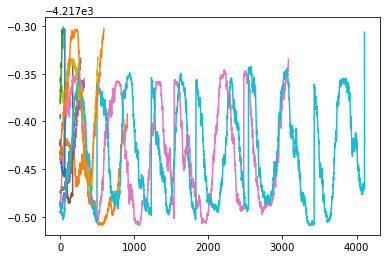

In [48]:
SHOW_PREVIEW=False
ep_rewards=[]
angles_list=[]
#energy_min=-1941.0 #This needs to be defined for each structure. This should be the open babel gradient descent min. 
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):

    #while env.EXIT==False:

    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1

    # Reset environment and get initial state
    current_state = env.reset()

    # Reset flag and start iterating until episode ends
    done = False
    while not done:

        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(agent.get_qs(current_state,step))
        else:
            # Get random action
            action = np.random.randint(0, env.ACTION_SPACE_SIZE)

        new_state, reward, done, ANGLES = env.step(action)
        angles_list.append(ANGLES)
        

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

        if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
            env.render()

        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done, step)

        current_state = new_state
        step += 1
    #episode+=1
    #print("DONE")
    # Append episode reward to a list and log stats (every given number of episodes)
    ep_rewards.append(episode_reward)
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        #agent.tensorboard.update_stats(reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon)

        # Save model, but only when min reward is greater or equal a set value
        #if min_reward >= MIN_REWARD:
            #agent.model.save(f'models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.model')

    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)
plt.legend([str(i) for i in range(EPISODES)])


In [16]:
def create_model(self):
        
        model = Sequential(name = 'DQN: Ethanol')
        #model.add(Conv2D(256, (3, 3), input_shape=env.OBSERVATION_SPACE_VALUES))
        #model.add(keras.Input(shape=(REPLAY_MEMORY_SIZE,a1.n_choices)))
        model.add(keras.Input(shape=(a1.n_choices)))
        model.add(Dense(a1.n_choices))

        #model.add(Flatten())
        
        model.add(Dense(a1.n_choices,activation='linear'))

        model.add(Dense(env.ACTION_SPACE_SIZE, activation='linear'))
        model.compile(loss="mse", optimizer=Adam(lr=0.001), metrics=['accuracy'])
        return model

In [17]:
model = create_model(env)

In [18]:
model.summary()

Model: "DQN: Ethanol"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 12        
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________


In [19]:
pydot.find_graphviz()

In [22]:
visualizer(model, filename = r"C:\Users\ascoh\viz_ethanol", format = 'png', view = True)

In [27]:
env.energy_list

[]